In [1]:
!pip install torch transformers datasets nltk seaborn matplotlib rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using ca

In [4]:
# Import libraries
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration
import torch.optim as optim
from datasets import load_dataset
from rouge_score import rouge_scorer

# Download NLTK tokenizer data
nltk.download('punkt')

# Load and Preprocess the Dataset
# Load only a very small subset of the CNN/Daily Mail dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')  # Load the full dataset first
small_train_dataset = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.001))) # Select 0.1% after shuffling

# Convert to DataFrame and save to CSV
df = pd.DataFrame({
    'text': small_train_dataset['article'],
    'summary': small_train_dataset['highlights']
})

df.to_csv('cnn_dailymail_very_small_data.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


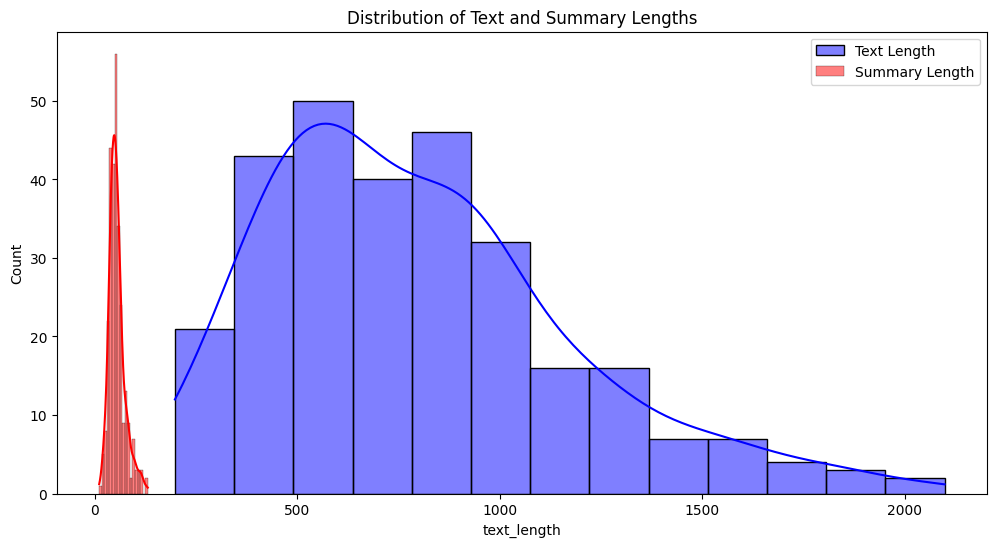

In [5]:
# Data insights
df['text_length'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['summary_length'] = df['summary'].apply(lambda x: len(nltk.word_tokenize(x)))

plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, color='blue', label='Text Length')
sns.histplot(df['summary_length'], kde=True, color='red', label='Summary Length')
plt.legend()
plt.title('Distribution of Text and Summary Lengths')
plt.show()

In [6]:

# Define the Dataset Class
class CustomTextDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')  # Use a smaller model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx, 0]
        summary = self.data.iloc[idx, 1]
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        targets = self.tokenizer(summary, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
        return inputs.input_ids.squeeze(), targets.input_ids.squeeze()

In [7]:
# Load dataset
data = pd.read_csv('cnn_dailymail_very_small_data.csv')
train_dataset = CustomTextDataset(data)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Reduce batch size


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [9]:
# Model Definition and Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device)  # Use a smaller model
optimizer = optim.AdamW(model.parameters(), lr=3e-5)


In [10]:
num_epochs = 1  # Reduce the number of epochs
training_loss = []

In [11]:
# Train the model minimally
model.train()
total_loss = 0
for batch in train_dataloader:
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(input_ids=inputs, labels=targets)
    loss = outputs.loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    break  # Train on just one batch for demonstration purposes


In [12]:
avg_loss = total_loss / 1
training_loss.append(avg_loss)
print(f'Training Loss: {avg_loss}')

Training Loss: 9.115382194519043


In [13]:
# Save the model
model.save_pretrained('summarization_model_demo')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


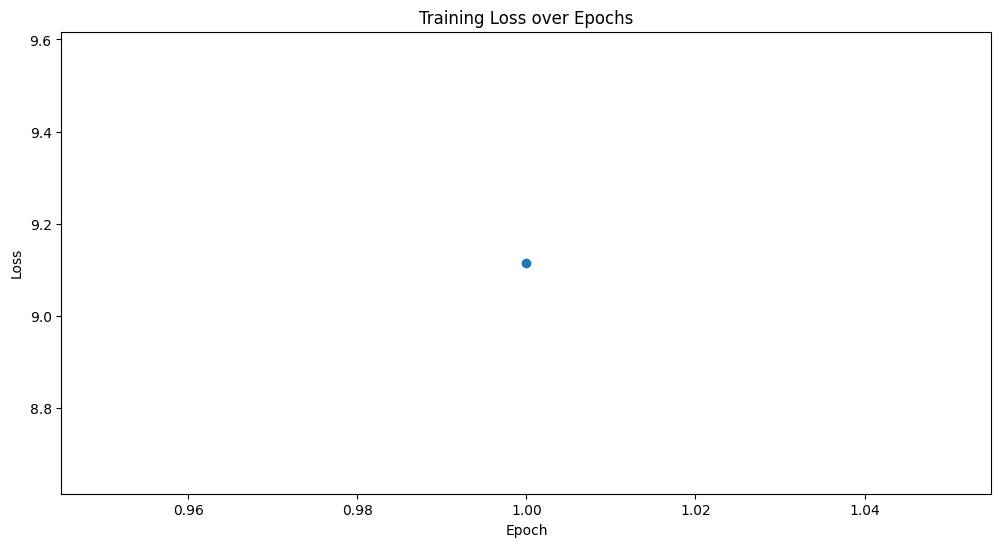

In [14]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [24]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')


In [28]:
# Define the Evaluation Function
def evaluate_model(model, dataloader, tokenizer, num_samples=5):
    model.eval()
    summaries = []
    references = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:  # Limit the number of samples for evaluation
                break
            inputs, targets = batch
            inputs = inputs.to(device)
            outputs = model.generate(inputs)
            decoded_summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in outputs]
            decoded_references = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=False) for t in targets]
            summaries.extend(decoded_summaries)
            references.extend(decoded_references)
    return summaries, references

In [29]:
val_summaries, val_references = evaluate_model(model, train_dataloader, tokenizer)


In [30]:
# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = { 'rouge1': [], 'rouge2': [], 'rougeL': [] }

for summary, reference in zip(val_summaries, val_references):
    scores = scorer.score(reference, summary)
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

In [31]:
# Average ROUGE scores
avg_rouge_scores = {k: sum(v) / len(v) for k, v in rouge_scores.items()}

In [32]:
# Print ROUGE scores
print("ROUGE-1: ", avg_rouge_scores['rouge1'])
print("ROUGE-2: ", avg_rouge_scores['rouge2'])
print("ROUGE-L: ", avg_rouge_scores['rougeL'])

ROUGE-1:  0.10396894285080069
ROUGE-2:  0.013119958365860005
ROUGE-L:  0.0879593331004198


In [33]:

# Visualize ROUGE scores
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [avg_rouge_scores['rouge1'], avg_rouge_scores['rouge2'], avg_rouge_scores['rougeL']]


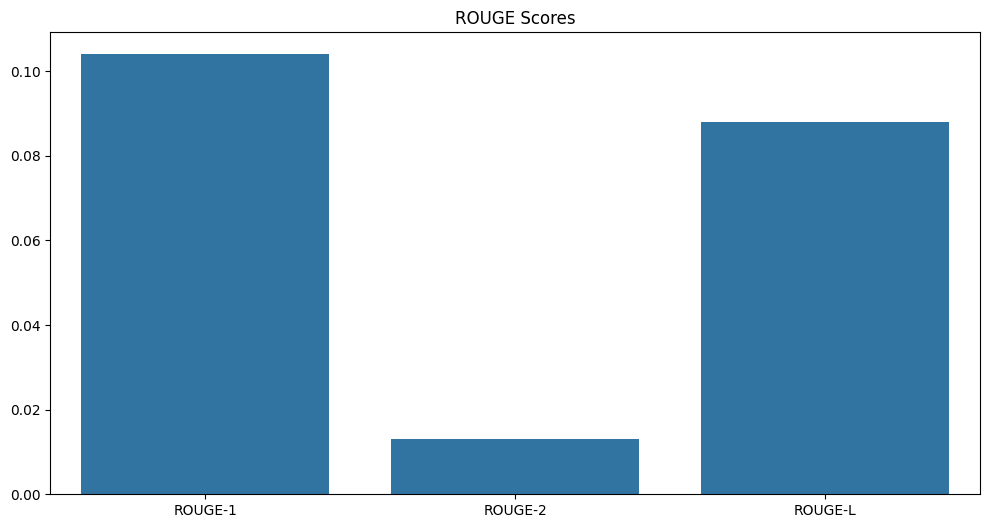

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=scores)
plt.title('ROUGE Scores')
plt.show()

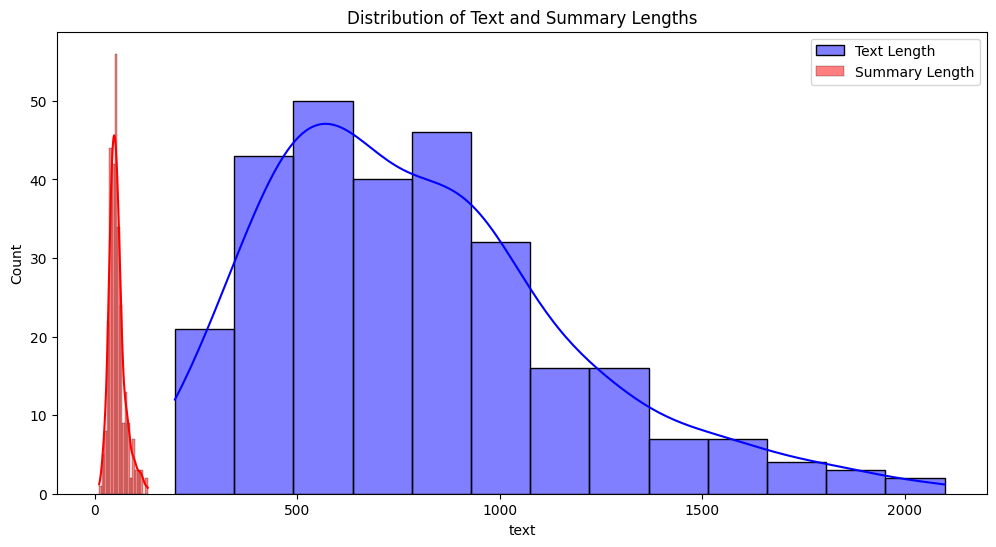

Text Length Statistics:
count     287.000000
mean      798.864111
std       374.728413
min       198.000000
25%       511.500000
50%       728.000000
75%      1000.000000
max      2098.000000
Name: text, dtype: float64

Summary Length Statistics:
count    287.000000
mean      54.756098
std       19.620252
min       11.000000
25%       42.000000
50%       51.000000
75%       63.000000
max      131.000000
Name: summary, dtype: float64


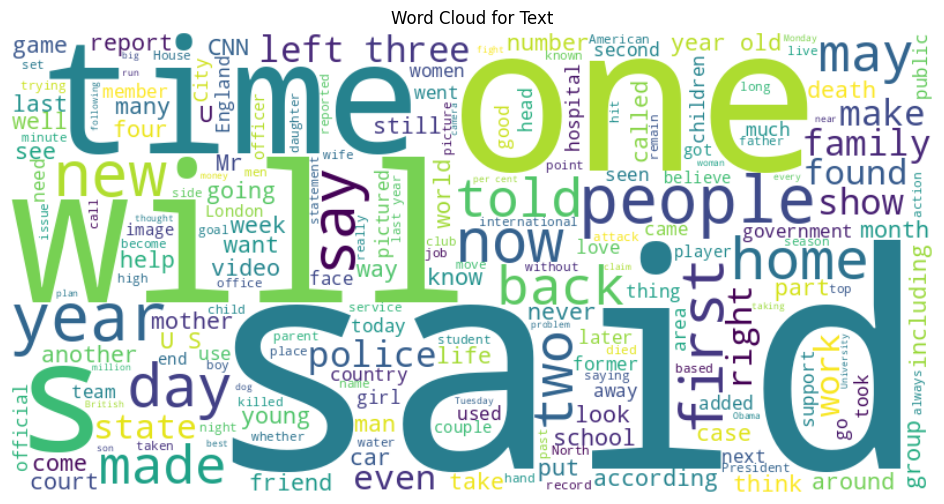

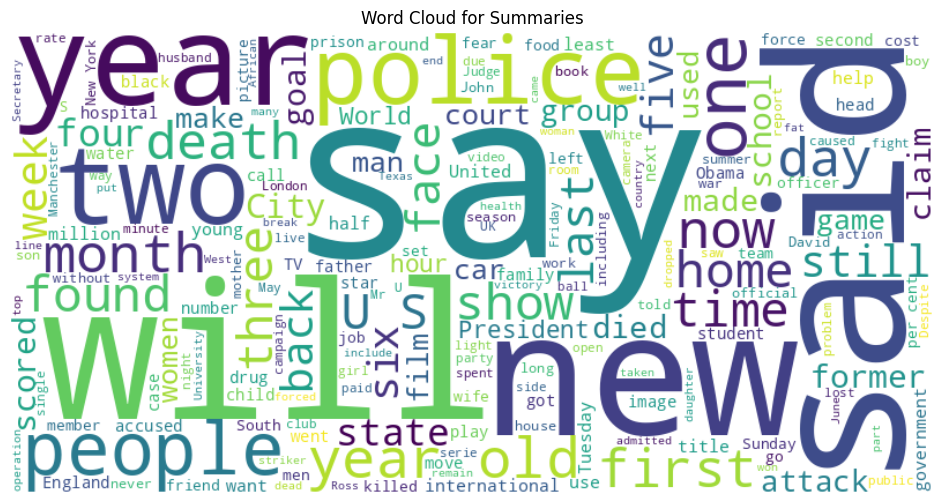

In [35]:
# Text length statistics
text_lengths = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
summary_lengths = df['summary'].apply(lambda x: len(nltk.word_tokenize(x)))

# Plot histograms of text and summary lengths
plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, kde=True, color='blue', label='Text Length')
sns.histplot(summary_lengths, kde=True, color='red', label='Summary Length')
plt.legend()
plt.title('Distribution of Text and Summary Lengths')
plt.show()

# Display basic statistics
print("Text Length Statistics:")
print(text_lengths.describe())

print("\nSummary Length Statistics:")
print(summary_lengths.describe())

# Word cloud visualization
from wordcloud import WordCloud

text_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['text']))
summary_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['summary']))

plt.figure(figsize=(12, 6))
plt.imshow(text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(summary_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Summaries')
plt.show()


In [37]:
!pip install nltk
import nltk
nltk.download('stopwords')

import re
import string

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english')) # Now this line should work
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

df['clean_text'] = df['text'].apply(preprocess_text)
df['clean_summary'] = df['summary'].apply(preprocess_text)

# Display preprocessed text
print(df[['text', 'clean_text']].head())
print(df[['summary', 'clean_summary']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                text  \
0  By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 ...   
1  UNITED NATIONS (CNN) -- A rare meeting of U.N....   
2  Cover-up: Former Archbishop Lord Hope allowed ...   
3  By . Kristie Lau . PUBLISHED: . 10:48 EST, 14 ...   
4  'The lamps are going out all over Europe. We s...   

                                          clean_text  
0  anthony bond published 0703 est 2 march 2013 u...  
1  united nations cnn rare meeting un security co...  
2  coverup former archbishop lord hope allowed pa...  
3  kristie lau published 1048 est 14 june 2012 up...  
4  lamps going europe shall see lit lifetime fore...  
                                             summary  \
0  John and .\nAudrey Cook were discovered alongs...   
1  NEW: Libya can serve as example of cooperation...   
2  Very Reverend Robert Waddington sexually abuse...   
3  Monday night's episode showed Buddy Valastro t...   
4  People asked to turn out lights for hour betwe... 

In [46]:
# Error Analysis Function
def error_analysis(summaries, references):
    for i, (summary, reference) in enumerate(zip(summaries, references)):
        print(f"Sample {i + 1}")
        print("Reference:", reference)
        print("Generated Summary:", summary)
        print()

error_analysis(val_summaries, val_references)

Sample 1
Reference: Euro 2012, Olympics tickets and Whitney Houston most searched in 2012 .
Olympian and Strictly contestant Victoria Pendleton tops reality TV stars .
Psy's Gangnam Style most trending song, Skyfall most enquired-about film .
Justin Bieber and Selena Gomez head list of Googled celebrity break-ups .
Synchronised swimming and 'murderball' are most searched-for sports .
Generated Summary: It was the year London hosted one of the most successful Olympics in memory, an eagerly

Sample 2
Reference: The area surrounding the lake was in the 80s this weekend but 5% is still frozen over .
Brave beach-goers in Duluth, Minnesota posed for photos on the mini-ice caps during breaks from laying out in the sun .
Generated Summary: Sunbathers would not let a long winter stop them from hitting the beach in

Sample 3
Reference: Russian President Vladimir Putin made the statement on national TV today .
But Putin also warned of future disputes over U.S.-led NATO plans for a missile-defense

In [48]:
!pip install textstat # Install the 'textstat' library
from textstat import textstat # Import the necessary module

df['text_readability'] = df['clean_text'].apply(lambda x: textstat.flesch_reading_ease(x))
df['summary_readability'] = df['clean_summary'].apply(lambda x: textstat.flesch_reading_ease(x))

print(df[['clean_text', 'text_readability']].head())
print(df[['clean_summary', 'summary_readability']].head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
                                          clean_text  text_readability
0  anthony bond published 0703 est 2 march 2013 u...           -229.31
1  united nations cnn rare meeting un security co...           -541.26
2  coverup former archbishop lord hope allowed pa...           -242.17
3  kristie lau published 1048 est 14 june 2012 up...           -491.18
4  lamps going europe shall see lit lifetime fore...           -216.12
                                       clean_summary  summary_readability
0  john audrey cook discovered alongside daughter...                35.27
1  new libya serve example cooperation white hous...                19.03
2  reverend robert waddington sexually abused cho...                48.47
3  monday nights episode showed buddy valastro tr...                33.24
4  people asked turn lights hour 10 11pm tom

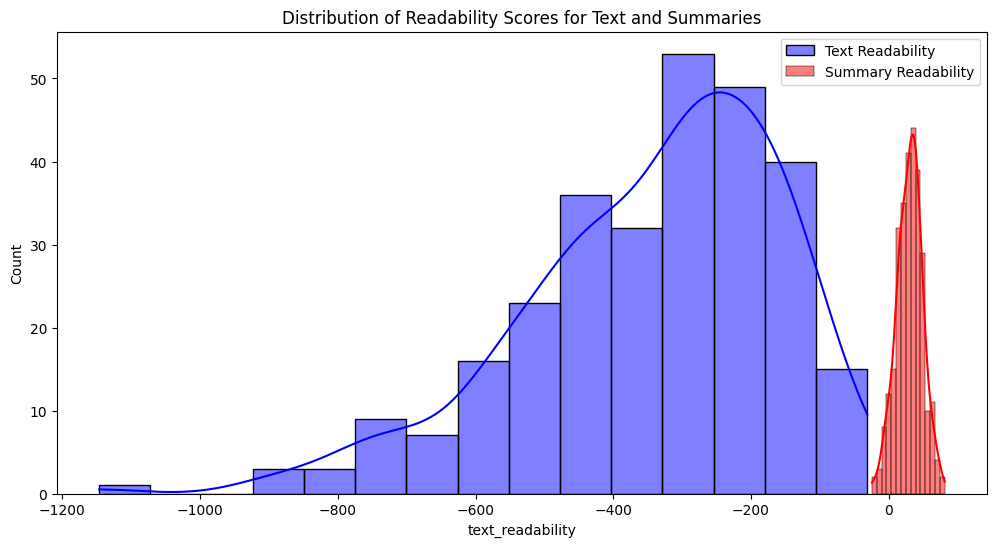

In [53]:
# Visualize Readability Scores
plt.figure(figsize=(12, 6))
sns.histplot(df['text_readability'], kde=True, color='blue', label='Text Readability')
sns.histplot(df['summary_readability'], kde=True, color='red', label='Summary Readability')
plt.legend()
plt.title('Distribution of Readability Scores for Text and Summaries')
plt.show()



